# Prepare the Data

In [41]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import pylab as pl
from pyramid.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter("ignore")

In [42]:
stock_price_df = pd.read_csv("./20industries_ETF_prc_UNSTACKED.csv")
portfolio = stock_price_df.columns[1:]
stock_num = len(portfolio) # exclude datadate
window_len = 100
dp_num = stock_price_df.shape[0]
corr_num = dp_num - window_len


In [43]:
def normalize_returns(r_df):
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) /sd_r
    return normed_df

In [44]:
def rolling_corr(item1,item2):
    #import data
    stock_price_df = pd.read_csv("./20industries_ETF_prc_UNSTACKED.csv")
    pd.to_datetime(stock_price_df['datadate'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['datadate']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_pair.columns = [item1,item2]
    df_pair = normalize_returns(df_pair)
    df_pair = df_pair.ewm(halflife=100/12).mean()
    df_corr = df_pair[item1].rolling(window=window_len).corr(df_pair[item2])
    return df_corr


In [45]:
index_list = []
for _ in range(window_len):
    indices = []
    for k in range(_, corr_num,window_len):
        indices.append(k)
    index_list.append(indices)
    


In [46]:
data_matrix = []
count = 0
for i in range(stock_num):
    for j in range(stock_num - 1 -i):
        a = portfolio[i]
        b = portfolio[stock_num-1-j]
        print(i, stock_num-1-j)
        corr_series = rolling_corr(a, b)[window_len-1:]

        for _ in range(100):
            tmp = corr_series[index_list[_]]
            corr_strided = list(tmp[:corr_num//window_len]).copy()
            data_matrix.append(corr_strided)
            count+=1
            # if count % 1000 == 0 :
            #     print(str(count)+' items preprocessed')
                


0 19
0 18
0 17
0 16
0 15
0 14
0 13
0 12
0 11
0 10
0 9
0 8
0 7
0 6
0 5
0 4
0 3
0 2
0 1
1 19
1 18
1 17
1 16
1 15
1 14
1 13
1 12
1 11
1 10
1 9
1 8
1 7
1 6
1 5
1 4
1 3
1 2
2 19
2 18
2 17
2 16
2 15
2 14
2 13
2 12
2 11
2 10
2 9
2 8
2 7
2 6
2 5
2 4
2 3
3 19
3 18
3 17
3 16
3 15
3 14
3 13
3 12
3 11
3 10
3 9
3 8
3 7
3 6
3 5
3 4
4 19
4 18
4 17
4 16
4 15
4 14
4 13
4 12
4 11
4 10
4 9
4 8
4 7
4 6
4 5
5 19
5 18
5 17
5 16
5 15
5 14
5 13
5 12
5 11
5 10
5 9
5 8
5 7
5 6
6 19
6 18
6 17
6 16
6 15
6 14
6 13
6 12
6 11
6 10
6 9
6 8
6 7
7 19
7 18
7 17
7 16
7 15
7 14
7 13
7 12
7 11
7 10
7 9
7 8
8 19
8 18
8 17
8 16
8 15
8 14
8 13
8 12
8 11
8 10
8 9
9 19
9 18
9 17
9 16
9 15
9 14
9 13
9 12
9 11
9 10
10 19
10 18
10 17
10 16
10 15
10 14
10 13
10 12
10 11
11 19
11 18
11 17
11 16
11 15
11 14
11 13
11 12
12 19
12 18
12 17
12 16
12 15
12 14
12 13
13 19
13 18
13 17
13 16
13 15
13 14
14 19
14 18
14 17
14 16
14 15
15 19
15 18
15 17
15 16
16 19
16 18
16 17
17 19
17 18
18 19


In [47]:
data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)
data_df.to_csv('./dataset.csv')


# model

In [48]:
data_df = pd.read_csv('./dataset.csv')
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
print(data_df.shape)

(19000, 31)


In [49]:
shape1=data_df.shape[1]
data_df.shape

(19000, 31)

In [50]:
num_list = []
for i in range(31):
    num_list.append(str(i))
data_df = data_df[num_list].copy()
data_df = np.transpose(data_df)
print(data_df.shape)
print(data_df.head())

(31, 19000)
      0         1         2         3         4         5         6      \
0  0.735596  0.760432  0.782987  0.802947  0.821891  0.840724  0.859620   
1  0.336218  0.362861  0.389192  0.416113  0.444440  0.472311  0.499678   
2  0.959626  0.960538  0.961495  0.962518  0.963556  0.964589  0.965583   
3  0.974181  0.973509  0.972590  0.971102  0.969305  0.967385  0.965260   
4  0.998502  0.998471  0.998433  0.998382  0.998315  0.998244  0.998168   

      7         8         9      ...     18990     18991     18992     18993  \
0  0.877712  0.894373  0.909033  ...  0.117876  0.106967  0.098010  0.091929   
1  0.527696  0.555833  0.583913  ...  0.831777  0.833079  0.833626  0.833399   
2  0.966540  0.967483  0.968398  ...  0.742016  0.727992  0.713514  0.698542   
3  0.963071  0.960832  0.958517  ...  0.990574  0.991235  0.991872  0.992484   
4  0.998084  0.997995  0.997906  ...  0.652544  0.696987  0.735088  0.767546   

      18994     18995     18996     18997     18998     

In [51]:
indices = [20*k for k in range(950)]
data_df = pd.DataFrame(data_df[indices])

train = []
dev = []
test1 = []
test2 = []

for i in range(data_df.shape[1]):
    tmp = data_df[20*i].copy()
    train.append(tmp[:(shape1-10)]) # 0:21  （0：20；  21）
    dev.append(tmp[3:(shape1-7)]) # 3：24   （    ；    ）
    test1.append(tmp[6:(shape1-3)]) # 6：27
    test2.append(tmp[10:shape1]) # 10：31

train = pd.DataFrame(train)
dev = pd.DataFrame(dev)
test1 = pd.DataFrame(test1)
test2 = pd.DataFrame(test2)

train.to_csv('./my_data/train_dev_test/before_arima/train.csv')
dev.to_csv('./my_data/train_dev_test/before_arima/dev.csv')
test1.to_csv('./my_data/train_dev_test/before_arima/test1.csv')
test2.to_csv('./my_data/train_dev_test/before_arima/test2.csv')


In [52]:
train = pd.read_csv('./my_data/train_dev_test/before_arima/train.csv')
dev = pd.read_csv('./my_data/train_dev_test/before_arima/dev.csv')
test1 = pd.read_csv('./my_data/train_dev_test/before_arima/test1.csv')
test2 = pd.read_csv('./my_data/train_dev_test/before_arima/test2.csv')

train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
dev = np.transpose(dev.loc[:,~dev.columns.str.contains('^Unnamed')])
test1 = np.transpose(test1.loc[:,~test1.columns.str.contains('^Unnamed')])
test2 = np.transpose(test2.loc[:,~test2.columns.str.contains('^Unnamed')])

datasets = [train, dev, test1, test2]

In [69]:
train.shape

(21, 950)

In [59]:
model_110 = ARIMA(order=(1,1,0), method='mle', suppress_warnings=True)
model_011 = ARIMA(order=(0,1,1), method='mle', suppress_warnings=True)
model_111 = ARIMA(order=(1,1,1), method='mle', suppress_warnings=True)
model_211 = ARIMA(order=(2,1,1), method='mle', suppress_warnings=True)
model_210 = ARIMA(order=(2,1,0), method='mle', suppress_warnings=True)

train_X = []; train_Y = []
dev_X = []; dev_Y = []
test1_X = []; test1_Y = []
test2_X = []; test2_Y = []

flag = 0

prediction_21st = []

for i in range(950):
    print(i)
    tmp = []
    c=0
    for s in datasets :
        c+=1
        try:
            model1 = model_110.fit(s[i])
            model = model1
            
            try:
                model2 = model_011.fit(s[i])
                
                if model.aic() <= model2.aic() :
                    pass
                else :
                    model = model2
                    
                try :
                    model3 = model_111.fit(s[i])
                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                    
            except:
                try:
                    model3 = model_111.fit(s[i])

                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
                
        except:
            try:
                model2 = model_011.fit(s[i])
                model = model2
            
                try :
                    model3 = model_111.fit(s[i])
                    
                    if model.aic() <= model3.aic():
                        pass
                    else:
                        model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            pass
            
            except :
                try:
                    model3 = model_111.fit(s[i])
                    model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])
                        
                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])
                            
                            if model.aic() <= model5.aic():
                                pass
                            else :
                                model = model5
                        except :
                            flag = 1
                            print(str(c) + " FATAL ERROR")
                            break
        


        
        predictions = list(model.predict_in_sample())
        #pad the first time step of predictions with the average of the prediction values
        #so as to match the length of the s[i] data
        predictions = [np.mean(predictions)] + predictions # [21]   * 950 iterations
        
        prediction_21st.append(predictions[-1])
        
        residual = pd.Series(np.array(s[i]) - np.array(predictions))
        tmp.append(np.array(residual))


    if flag == 1:
        break
    train_X.append(tmp[0][:20])
    train_Y.append(tmp[0][20])
    dev_X.append(tmp[1][:20])
    dev_Y.append(tmp[1][20])
    test1_X.append(tmp[2][:20])
    test1_Y.append(tmp[2][20])
    test2_X.append(tmp[3][:20])
    test2_Y.append(tmp[3][20])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
prediction_21st = np.array(prediction_21st)
prediction_21st

array([-0.05670299, -0.31477943, -0.25891605, ..., -0.61862703,
       -0.91171716, -0.27668108])

In [14]:
pd.DataFrame(train_X).to_csv('./my_data/train_dev_test/after_arima/train_X.csv')
pd.DataFrame(dev_X).to_csv('./my_data/train_dev_test/after_arima/dev_X.csv')
pd.DataFrame(test1_X).to_csv('./my_data/train_dev_test/after_arima/test1_X.csv')
pd.DataFrame(test2_X).to_csv('./my_data/train_dev_test/after_arima/test2_X.csv')
pd.DataFrame(train_Y).to_csv('./my_data/train_dev_test/after_arima/train_Y.csv')
pd.DataFrame(dev_Y).to_csv('./my_data/train_dev_test/after_arima/dev_Y.csv')
pd.DataFrame(test1_Y).to_csv('./my_data/train_dev_test/after_arima/test1_Y.csv')
pd.DataFrame(test2_Y).to_csv('./my_data/train_dev_test/after_arima/test2_Y.csv')

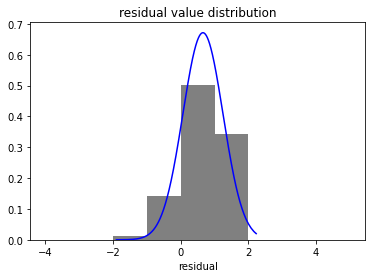

0.0007158836689038032 % of the data is out of bound [-2,2]
0.6030425055928411 % of the data is out of bound [-1,1]


In [15]:
train = pd.read_csv('./my_data/train_dev_test/after_arima/train_X.csv')
train = np.transpose(train.loc[:,~train.columns.str.contains('^Unnamed')])
train_melt = sorted(np.array(train.melt()['value']))
fit = stats.norm.pdf(train_melt, np.mean(train_melt), np.std(train_melt))
pl.hist(train_melt,density=True, color='grey', bins=[-4,-3,-2,-1,0,1,2,3,4,5])
pl.plot(train_melt,fit,color='blue')
pl.title('residual value distribution')
pl.xlabel('residual')
pl.show()
pl.close()

X = [x for x in train_melt if x>2]
Y = [y for y in train_melt if y<-2]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-2,2]')

X = [x for x in train_melt if x>1]
Y = [y for y in train_melt if y<-1]
out_of_bound = X + Y
print(str(len(out_of_bound)/11175) +' % of the data is out of bound [-1,1]')

In [16]:
stat = pd.DataFrame()
for i in range(190):
    df = train[i].describe()
    stat[i] = df
stat

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.857608,0.809016,0.809820,0.840703,0.891375,0.806982,0.753754,0.765899,0.706988,0.721054,...,0.643922,0.650732,0.673487,0.675382,0.687721,0.629792,0.611499,0.672020,0.739272,0.733342
std,0.415463,0.399509,0.360067,0.283767,0.450546,0.403639,0.521517,0.438191,0.634323,0.587508,...,0.575976,0.616642,0.485369,0.449595,0.681552,0.632418,0.660497,0.484928,0.287431,0.386691
min,-0.182239,0.065283,0.100846,0.153408,-0.400931,-0.261993,-0.220308,-0.426096,-1.234267,-1.254576,...,-0.569621,-0.758729,-0.661587,-0.508081,-1.176764,-0.668579,-0.586123,-0.755698,0.186525,-0.072571
25%,0.741909,0.521882,0.481639,0.677451,0.972234,0.655024,0.498473,0.517681,0.605701,0.578950,...,0.280808,0.621491,0.569162,0.341092,0.257886,0.357634,0.088013,0.568959,0.565151,0.512879
50%,1.074934,0.992658,0.985519,0.922792,1.006067,0.869793,0.865296,0.886864,0.937599,0.888179,...,0.956699,0.764753,0.682364,0.740769,0.921185,0.817256,0.910160,0.801487,0.791668,0.813032
75%,1.137954,1.086591,1.034051,0.991195,1.050990,1.043857,0.990546,1.076174,1.059541,1.031162,...,1.073093,1.073488,0.939227,1.058164,1.175713,1.145514,1.149919,0.981363,0.968504,1.063408
max,1.271372,1.256426,1.197243,1.279478,1.450451,1.309549,1.693783,1.281826,1.335333,1.419444,...,1.229897,1.267617,1.294056,1.229933,1.277378,1.327378,1.262594,1.175528,1.070674,1.199846


# Train LSTM

In [1]:
import pandas as pd
import numpy as np
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

train_X= pd.read_csv('./my_data/train_dev_test/after_arima/train_X.csv')
print('loaded train_X')
dev_X = pd.read_csv('./my_data/train_dev_test/after_arima/dev_X.csv')
print('loaded dev_X')
test1_X = pd.read_csv('./my_data/train_dev_test/after_arima/test1_X.csv')
print('loaded test1_X')
test2_X = pd.read_csv('./my_data/train_dev_test/after_arima/test2_X.csv')
print('loaded test2_X')
train_Y = pd.read_csv('./my_data/train_dev_test/after_arima/train_Y.csv')
print('loaded train_Y')
dev_Y = pd.read_csv('./my_data/train_dev_test/after_arima/dev_Y.csv')
print('loaded dev_Y')
test1_Y = pd.read_csv('./my_data/train_dev_test/after_arima/test1_Y.csv')
print('loaded test1_Y')
test2_Y = pd.read_csv('./my_data/train_dev_test/after_arima/test2_Y.csv')
print('loaded test2_Y')
train_X = train_X.loc[:, ~train_X.columns.str.contains('^Unnamed')]
dev_X = dev_X.loc[:, ~dev_X.columns.str.contains('^Unnamed')]
test1_X = test1_X.loc[:, ~test1_X.columns.str.contains('^Unnamed')]
test2_X = test2_X.loc[:, ~test2_X.columns.str.contains('^Unnamed')]
train_Y = train_Y.loc[:, ~train_Y.columns.str.contains('^Unnamed')]
dev_Y = dev_Y.loc[:, ~dev_Y.columns.str.contains('^Unnamed')]
test1_Y = test1_Y.loc[:, ~test1_Y.columns.str.contains('^Unnamed')]
test2_Y = test2_Y.loc[:, ~test2_Y.columns.str.contains('^Unnamed')]

# data sampling
STEP = 20
#num_list = [STEP*i for i in range(int(1117500/STEP))]

_train_X = np.asarray(train_X).reshape((int(950), 20, 1))
_dev_X = np.asarray(dev_X).reshape((int(950), 20, 1))
_test1_X = np.asarray(test1_X).reshape((int(950), 20, 1))
_test2_X = np.asarray(test2_X).reshape((int(950), 20, 1))

_train_Y = np.asarray(train_Y).reshape(int(950), 1)
_dev_Y = np.asarray(dev_Y).reshape(int(950), 1)
_test1_Y = np.asarray(test1_Y).reshape(int(950), 1)
_test2_Y = np.asarray(test2_Y).reshape(int(950), 1)


class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (2*K.tanh(x))

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})


# Model Generation
model = Sequential()
#check https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/
model.add(LSTM(25, input_shape=(20,1), dropout=0.0, kernel_regularizer=l1_l2(0.00,0.00), bias_regularizer=l1_l2(0.00,0.00)))
model.add(Dense(1))
model.add(Activation(double_tanh))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
#, kernel_regularizer=l1_l2(0,0.1), bias_regularizer=l1_l2(0,0.1),

print(model.metrics_names)


# Fitting the Model
model_scores = {}
Reg = False
d = 'hybrid_LSTM'

if Reg :
    d += '_with_reg'

epoch_num=1
for _ in range(124):

    # train the model
    dir = './models/'+d
    file_list = os.listdir(dir)
    if len(file_list) != 0 :
        epoch_num = len(file_list) + 1
        recent_model_name = 'epoch'+str(epoch_num-1)+'.h5'
        filepath = './models/' + d + '/' + recent_model_name
        model = load_model(filepath,custom_objects={'double_tanh': double_tanh})

    filepath = './models/' + d + '/epoch'+str(epoch_num)+'.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min')
    callbacks_list = [checkpoint]
    if len(callbacks_list) == 0:
        model.fit(_train_X, _train_Y, epochs=1, batch_size=500, shuffle=True)
    else:
        model.fit(_train_X, _train_Y, epochs=1, batch_size=500, shuffle=True, callbacks=callbacks_list)

    # test the model
    score_train = model.evaluate(_train_X, _train_Y)
    score_dev = model.evaluate(_dev_X, _dev_Y)
    score_test1 = model.evaluate(_test1_X, _test1_Y)
    score_test2 = model.evaluate(_test2_X, _test2_Y)

    print('train set score : mse - ' + str(score_train[1]) +' / mae - ' + str(score_train[2]))
    print('dev set score : mse - ' + str(score_dev[1]) +' / mae - ' + str(score_dev[2]))
    print('test1 set score : mse - ' + str(score_test1[1]) +' / mae - ' + str(score_test1[2]))
    print('test2 set score : mse - ' + str(score_test2[1]) +' / mae - ' + str(score_test2[2]))
#.history['mean_squared_error'][0]
    # get former score data
    df = pd.read_csv("./models/"+d+".csv")
    train_mse = list(df['TRAIN_MSE'])
    dev_mse = list(df['DEV_MSE'])
    test1_mse = list(df['TEST1_MSE'])
    test2_mse = list(df['TEST2_MSE'])

    train_mae = list(df['TRAIN_MAE'])
    dev_mae = list(df['DEV_MAE'])
    test1_mae = list(df['TEST1_MAE'])
    test2_mae = list(df['TEST2_MAE'])

    # append new data
    train_mse.append(score_train[1])
    dev_mse.append(score_dev[1])
    test1_mse.append(score_test1[1])
    test2_mse.append(score_test2[1])

    train_mae.append(score_train[2])
    dev_mae.append(score_dev[2])
    test1_mae.append(score_test1[2])
    test2_mae.append(score_test2[2])

    # organize newly created score dataset
    model_scores['TRAIN_MSE'] = train_mse
    model_scores['DEV_MSE'] = dev_mse
    model_scores['TEST1_MSE'] = test1_mse
    model_scores['TEST2_MSE'] = test2_mse

    model_scores['TRAIN_MAE'] = train_mae
    model_scores['DEV_MAE'] = dev_mae
    model_scores['TEST1_MAE'] = test1_mae
    model_scores['TEST2_MAE'] = test2_mae

    # save newly created score dataset
    model_scores_df = pd.DataFrame(model_scores)
    model_scores_df.to_csv("./models/"+d+".csv")

loaded train_X
loaded dev_X
loaded test1_X
loaded test2_X
loaded train_Y
loaded dev_Y
loaded test1_Y
loaded test2_Y
[]
2/2 [==============================] - 1s 12ms/step - loss: 0.2635 - mse: 0.2635 - mae: 0.4127

Epoch 00001: saving model to ./models/hybrid_LSTM\epoch263.h5
30/30 [==============================] - 0s 1ms/step - loss: 0.3116 - mse: 0.3116 - mae: 0.4779
train set score : mse - 0.26328474283218384 / mae - 0.4165594279766083
dev set score : mse - 0.22368231415748596 / mae - 0.3904370069503784
test1 set score : mse - 0.3061307668685913 / mae - 0.45125630497932434
test2 set score : mse - 0.31161633133888245 / mae - 0.47793981432914734
2/2 [==============================] - 1s 12ms/step - loss: 0.2637 - mse: 0.2637 - mae: 0.4124

Epoch 00001: saving model to ./models/hybrid_LSTM\epoch264.h5
30/30 [==============================] - 0s 1ms/step - loss: 0.3017 - mse: 0.3017 - mae: 0.4643
train set score : mse - 0.2630104720592499 / mae - 0.4060969054698944
dev set score : mse 

<AxesSubplot:>

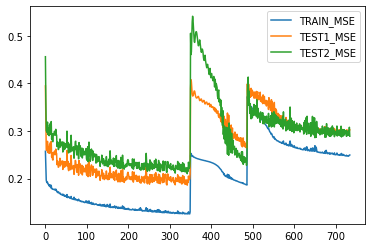

In [5]:
model_scores_df[['TRAIN_MSE', 'TEST1_MSE', 'TEST2_MSE']].plot()

<AxesSubplot:>

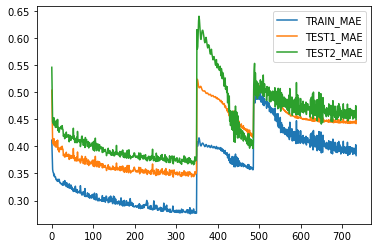

In [6]:
model_scores_df[['TRAIN_MAE',  'TEST1_MAE', 'TEST2_MAE']].plot()